In [1]:
# increase filters to 256

import os
from math import floor

import Bio.SeqIO as SeqIO
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model

import sys  
sys.path.append('../../../src')
from metrics import *

from pandas.core.common import flatten

In [2]:
model_name = "jason_cnn_2_3"

In [3]:
class BatchGenerator(keras.utils.Sequence):
    """Label, batch, and pad protein sequence data.

    Only complete batches are returned, so a single epoch may not train on every example."""
    def __init__(self, records, batch_size, sym_codes, shuffle=True):
        self.records = records
        self.indices = np.arange(len(self.records))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ctable = {}  # Category table
        for i, sym_code in enumerate(sym_codes):
            self.ctable[sym_code] = i
        self.on_epoch_end()

    def __len__(self):
        """Return number of batches."""
        return floor(len(self.records) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data."""
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        records = [self.records[i] for i in indices]
        max_len = max([len(record[0]) for record in records])
        x = np.zeros((self.batch_size, max_len))
        y = np.zeros((self.batch_size, max_len))
        for i, (syms, labels) in enumerate(records):
            x[i, :len(syms)] = [self.ctable.get(sym, 0) for sym in syms]
            y[i, :len(syms)] = [int(label) for label in labels]

        x = keras.utils.to_categorical(x, num_classes=len(self.ctable))
        y = keras.utils.to_categorical(y, num_classes=2)
        for i, (syms, _) in enumerate(records):
            x[i, len(syms):, :] = 0
            y[i, len(syms):, :] = 0
        return x, y

    def on_epoch_end(self):
        """Shuffles data after each epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)

def load_data(seqs_path, labels_path):
    # Load files
    seqs = {}
    for record in SeqIO.parse(seqs_path, 'fasta'):
        accession = record.description.split('|')[0]
        seq = str(record.seq)
        seqs[accession] = seq
    labels = {}
    for record in SeqIO.parse(labels_path, 'fasta'):
        accession = record.description.split('|')[0]
        label = str(record.seq)
        labels[accession] = label

    # Bundle seqs and labels into single object
    records = []
    for accession, seq in seqs.items():
        records.append((seq, labels[accession]))

    return records

def decode_sym(batch, sym_codes):
    """Decodes residue symbols in batch of proteins from encoded form."""
    ctable, i = {}, 0
    for sym_code in sym_codes:
        ctable[i] = sym_code
        i += 1
        
    decoded_sym = []
    for protein in batch:
        decoded_protein = []
        for residue in protein:
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = ctable[np.argmax(residue)]
                decoded_protein.append(decoded_residue)
        decoded_sym.append("".join(decoded_protein))
                           
    return decoded_sym

def decode_label_by_protein(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of str where each str is labels of one protein.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        decoded_protein = []
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_protein.append(str(decoded_residue))
        decoded_labels.append("".join(decoded_protein))
    return decoded_labels

def decode_label_to_lst(batch_to_be_decoded, original_batch):
    """
    Decodes residue labels in batch of proteins from encoded form.
    Outputs list of int where each int is label for one residue.
    
    batch_to_be_decoded:
    batch of labels which want to be decoded
    
    original_batch:
    original batch of labels generated by BatchGenerator which
    batch_to_be_decoded is derived from (this is needed in order
    to remove unwanted masked values)
    """
    decoded_labels = []
    for x in np.arange(len(original_batch)):
        protein = original_batch[x]
        for y in np.arange(len(protein)):
            residue = protein[y]
            if sum(residue) == 0:
                pass
            else:
                decoded_residue = np.argmax(batch_to_be_decoded[x][y])
                decoded_labels.append(decoded_residue)
    return decoded_labels
                           
class MaskedConv1D(keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True

In [4]:
# Parameters
sym_codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
             'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [5]:
# Load data
train_records = load_data('../../mobidb_validation/split_data/out/train_as_fasta.fasta', '../../mobidb_validation/split_data/out/train_labels_as_fasta.fasta')
validation_records = load_data('../../mobidb_validation/split_data/out/val_as_fasta.fasta', '../../mobidb_validation/split_data/out/val_labels_as_fasta.fasta')
test_records = load_data('../../mobidb_validation/split_data/out/test_as_fasta.fasta', '../../mobidb_validation/split_data/out/test_labels_as_fasta.fasta')

In [6]:
# Batch data
train_batches = BatchGenerator(train_records, 32, sym_codes)
validation_batches = BatchGenerator(validation_records, 32, sym_codes)
test_batches = BatchGenerator(test_records, 32, sym_codes)

In [15]:
# Build model
inputs = keras.layers.Input(shape=(None, 20), name='input1')
x = layers.Masking(mask_value=0, name='mask1')(inputs)
x = MaskedConv1D(256, 20, padding='same', activation='relu', name='conv1d1')(x)
x = MaskedConv1D(256, 20, padding='same', activation='relu', name='conv1d2')(x)
outputs = layers.Dense(2, activation='softmax', name='dense1')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

Model: "jason_cnn_2_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, None, 20)]        0         
_________________________________________________________________
mask1 (Masking)              (None, None, 20)          0         
_________________________________________________________________
conv1d1 (MaskedConv1D)       (None, None, 256)         102656    
_________________________________________________________________
conv1d2 (MaskedConv1D)       (None, None, 256)         1310976   
_________________________________________________________________
dense1 (Dense)               (None, None, 2)           514       
Total params: 1,414,146
Trainable params: 1,414,146
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Train model
# Epochs are written explicitly in a training loop since Keras
# does not support generators for calculating validation metrics

num_epochs = 50

histories = []

metrics_df = pd.DataFrame()

for i in range(num_epochs):
    # Fit
    print(f'EPOCH {i}')
    history = model.fit(train_batches, epochs=1)
    histories.append(history)

    # Evaluate
    true_labels = []
    pred_labels = []
    for batch in validation_batches:
        true_labels.append(decode_label_to_lst(batch[1], batch[1]))
        pred_labels.append(decode_label_to_lst(model.predict(batch[0]), batch[1]))
    true_labels = list(flatten(true_labels))
    pred_labels = list(flatten(pred_labels))
    
    batch_metrics_df = get_binary_metrics(true_labels, pred_labels)
    print("Label Accuracy:", batch_metrics_df.loc[0].at["Accuracy"])
    
    metrics_df = metrics_df.append(batch_metrics_df, ignore_index = True)

EPOCH 0
543/543 [==============================] - 1640s 3s/step - loss: 0.0564 - binary_accuracy: 0.9373
Label Accuracy: 0.9315249496293921
EPOCH 1
543/543 [==============================] - 1598s 3s/step - loss: 0.0550 - binary_accuracy: 0.9384
Label Accuracy: 0.9315249496293921
EPOCH 2
543/543 [==============================] - 1722s 3s/step - loss: 0.0531 - binary_accuracy: 0.9385
Label Accuracy: 0.9315249496293921
EPOCH 3
543/543 [==============================] - 1727s 3s/step - loss: 0.0515 - binary_accuracy: 0.9385
Label Accuracy: 0.931309558535186
EPOCH 4
543/543 [==============================] - 1623s 3s/step - loss: 0.0501 - binary_accuracy: 0.9386
Label Accuracy: 0.9312303564287964
EPOCH 5
543/543 [==============================] - 1597s 3s/step - loss: 0.0491 - binary_accuracy: 0.9390
Label Accuracy: 0.9302258419087321
EPOCH 6
543/543 [==============================] - 1618s 3s/step - loss: 0.0451 - binary_accuracy: 0.9400
Label Accuracy: 0.9273861566308583
EPOCH 7
543/54

In [8]:
metrics_df

,Accuracy,MCC,Sensitivity,Specificity,Precision,F1
0,0.931525,0.000000,0.000000,1.000000,0.000000,0.000000
1,0.931525,0.000000,0.000000,1.000000,0.000000,0.000000
2,0.931525,0.000000,0.000000,1.000000,0.000000,0.000000
3,0.931310,0.060500,0.010946,0.998964,0.437183,0.021357
4,0.931230,0.061062,0.011694,0.998824,0.422313,0.022757
5,0.930226,0.104991,0.037309,0.995863,0.398644,0.068233
6,0.927386,0.125589,0.066000,0.990705,0.342960,0.110697
7,0.926693,0.121103,0.066183,0.989947,0.326128,0.110036
8,0.918952,0.126440,0.101264,0.979059,0.262247,0.146109
9,0.923006,0.115125,0.077200,0.985180,0.276890,0.120737


In [9]:
balanced_accuracy = (metrics_df["Sensitivity"].values[49]+metrics_df["Specificity"].values[49])/2
balanced_accuracy

0.5364835964672932

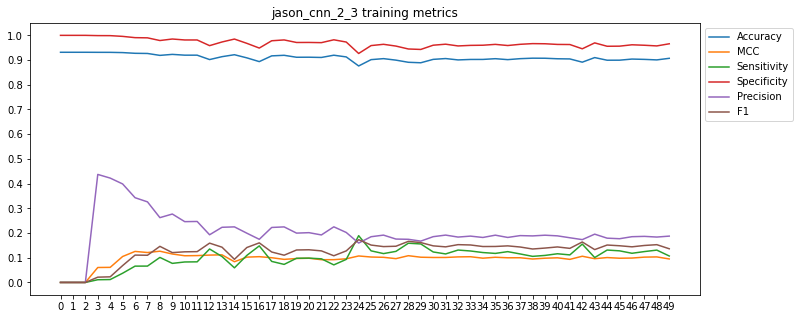

In [18]:
x_axis_ticks = np.arange(num_epochs)
y_axis_ticks = np.arange(11)/10

metrics_fig = metrics_df.plot(figsize = (12, 5), use_index = True, title = model_name + " training metrics", 
                              xticks = x_axis_ticks, yticks = y_axis_ticks)

metrics_fig = metrics_fig.legend(bbox_to_anchor=(1, 1))
metrics_fig = metrics_fig.get_figure()

In [19]:
# Save model
if not os.path.exists('out_model/'):
    os.mkdir('out_model/')

model.save('out_model/' + model_name + ".h5")

In [20]:
# Save metrics df
if not os.path.exists('out_metrics/'):
    os.mkdir('out_metrics/')

metrics_df.to_csv("out_metrics/training_metrics.csv", index=False)

In [21]:
model = load_model("out_model/" + model_name + ".h5", custom_objects={"MaskedConv1D": MaskedConv1D})

In [7]:
metrics_df = pd.read_csv ("out_metrics/training_metrics.csv")